In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits as pyfits
from astropy import wcs
import os, glob, sys
import scipy.interpolate as scint
import scipy.ndimage
import scipy.optimize as scopt

import matplotlib.pyplot as plt

# METHOD: BIN DOWN IMAGES

In [3]:
#http://scipy.github.io/old-wiki/pages/Cookbook/Rebinning

def congrid(a, newdims, method='linear', centre=False, minusone=False):
    '''Arbitrary resampling of source array to new dimension sizes.
    Currently only supports maintaining the same number of dimensions.
    To use 1-D arrays, first promote them to shape (x,1).
    
    Uses the same parameters and creates the same co-ordinate lookup points
    as IDL''s congrid routine, which apparently originally came from a VAX/VMS
    routine of the same name.

    method:
    neighbour - closest value from original data
    nearest and linear - uses n x 1-D interpolations using
                         scipy.interpolate.interp1d
    (see Numerical Recipes for validity of use of n 1-D interpolations)
    spline - uses ndimage.map_coordinates

    centre:
    True - interpolation points are at the centres of the bins
    False - points are at the front edge of the bin

    minusone:
    For example- inarray.shape = (i,j) & new dimensions = (x,y)
    False - inarray is resampled by factors of (i/x) * (j/y)
    True - inarray is resampled by(i-1)/(x-1) * (j-1)/(y-1)
    This prevents extrapolation one element beyond bounds of input array.
    '''
    if not a.dtype in [np.float64, np.float32]:
        a = np.cast[float](a)
    
    m1 = np.cast[int](minusone)
    ofs = np.cast[int](centre) * 0.5
    old = np.array( a.shape )
    ndims = len( a.shape )
    if len( newdims ) != ndims:
        print "[congrid] dimensions error. " \
              "This routine currently only support " \
              "rebinning to the same number of dimensions."
        return None
    newdims = np.asarray( newdims, dtype=float )    
    dimlist = []

    if method == 'neighbour':
        for i in range( ndims ):
            base = np.indices(newdims)[i]
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        cd = np.array( dimlist ).round().astype(int)
        newa = a[list( cd )]
        return newa
    
    elif method in ['nearest','linear']:
        # calculate new dims
        for i in range( ndims ):
            base = np.arange( newdims[i] )
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        # specify old dims
        olddims = [np.arange(i, dtype = np.float) for i in list( a.shape )]

        # first interpolation - for ndims = any
        mint = scipy.interpolate.interp1d( olddims[-1], a, kind=method )
        newa = mint( dimlist[-1] )

        trorder = [ndims - 1] + range( ndims - 1 )
        for i in range( ndims - 2, -1, -1 ):
            newa = newa.transpose( trorder )

            mint = scipy.interpolate.interp1d( olddims[i], newa, kind=method )
            newa = mint( dimlist[i] )

        if ndims > 1:
            # need one more transpose to return to original dimensions
            newa = newa.transpose( trorder )

        return newa
    elif method in ['spline']:
        oslices = [ slice(0,j) for j in old ]
        oldcoords = np.ogrid[oslices]
        nslices = [ slice(0,j) for j in list(newdims) ]
        newcoords = np.mgrid[nslices]

        newcoords_dims = range(np.rank(newcoords))
        #make first index last
        newcoords_dims.append(newcoords_dims.pop(0))
        newcoords_tr = newcoords.transpose(newcoords_dims)
        # makes a view that affects newcoords

        newcoords_tr += ofs        

        deltas = (np.asarray(old) - m1) / (newdims - m1)
        newcoords_tr *= deltas

        newcoords_tr -= ofs

        newa = scipy.ndimage.map_coordinates(a, newcoords)
        return newa
    else:
        print "Congrid error: Unrecognized interpolation type.\n", \
              "Currently only \'neighbour\', \'nearest\',\'linear\',", \
              "and \'spline\' are supported."
        return None  

# METHOD: READ APT POINTINGS FILE

In [66]:
def readPointingFile(fname):
    # READ APT POINTINGS FILE AND STRIP DITHERS/BASES:
    
    with open(fname) as f:
        content = f.read().splitlines()
    
    # FIND WHERE EACH OBSERVATION STARTS IN THE POINTINGS FILE:
    obs_start = [iline for iline in xrange(len(content)) if "==============" in content[iline]]
    obs_start.append(len(content))
    
    # GET ALL THE DITHERS FOR EACH OF THE OBSERVATIONS:
    dithers=[]
    for iobs in xrange( len(obs_start[:-1]) ):
        temp = content[obs_start[iobs]:obs_start[iobs+1]]
        
        temp = [x.split() for x in temp] # remove white spaces
        temp = filter(None, temp) # remove empty lines
    
        temp = [x for x in temp if "SCIENCE" in x]
    
        target  = np.array(  [float(i) for i in temp[0][7:9]] )
        dithers.append(np.array( [ [ (float(x[9])+float(x[11])), (-float(x[10])+float(x[12])) ] for x in temp] ) )

    return target, np.array(dithers)

# METHODS: CENTER PSF + GENERATE SEGMENT POSITIONS

In [67]:
def centerPSF(image):
    hdu = pyfits.open(image)
    sci = hdu[1].data

    com = scipy.ndimage.center_of_mass(sci) 
    com = [int(com[0]), int(com[1])]
    mid = len(sci)/2
        
    PSF = np.roll(sci, mid-com[0], axis=0)
    PSF = np.roll(PSF, mid-com[1], axis=1)
    
    PSF = np.asarray([PSF]*18)
    
    return PSF

def read18PSF(image):
    
    hdu = pyfits.open(image)
    PSF = hdu[0].data
    
    return PSF


def get_boresight_offset(sigma):
    return  np.random.normal(0., (sigma/np.sqrt(2)), (1,2))


def get_segment_offset(sigma):
    return np.random.normal(0., (sigma/np.sqrt(2)), (18,2))

# METHODS: ROTATE SCA/POINTS FOR PLOTTING

In [68]:
def shift_rotate_pts(points, rotation, dec):
    # FOR PLOTTING PURPOSES:
    temp = np.copy(points)
    angle = rotation * np.pi/180.

    points[:,0] = (temp[:,0]*np.cos(angle) - temp[:,1]*np.sin(angle) ) 
    points[:,1] = (temp[:,1]*np.cos(angle) + temp[:,0]*np.sin(angle) )
    
    points[:,0] /= np.cos(dec*np.pi/180.)

    return points


def shift_rotate_SCA(SCA, radangle, target, dither):
    xdith = dither[1]
    ydith = dither[0]

    tempSCA = np.copy(SCA)
    tempSCA[:,0]= SCA[:,0]*np.cos(radangle) - SCA[:,1]*np.sin(radangle) 
    tempSCA[:,1]= SCA[:,0]*np.sin(radangle) + SCA[:,1]*np.cos(radangle)

    xdith = dither[0]*np.sin(radangle) + dither[1]*np.cos(radangle)
    ydith = dither[0]*np.cos(radangle) - dither[1]*np.sin(radangle)

    xdith /= np.cos(target[1]*np.pi/180.)

    SCA[:,0] = tempSCA[:,0] + target[1] + ydith/3600.
    SCA[:,1] = tempSCA[:,1]/np.cos(target[1]*np.pi/180.) + target[0] + xdith/3600.
            
    return SCA

# CLASS: CREATE TILE OBJECT

In [79]:
class NRCtile():
    
        def __init__(self, target, rotation):   
            
            # ARCSECONDS:
            SCAgap  = 5.
            self.SCAwidth= 65.
            MODgap  = 44.
            MODwidth= SCAgap + 2.*self.SCAwidth
            self.radangle = rotation *np.pi/180.

            # DEFINE MIDDLE OF SCA's:
            self.SCA = np.asarray([
                [-MODwidth/2, +MODgap/2+MODwidth],              # A1
                [+SCAgap/2,   +MODgap/2+MODwidth],              # A2
                [-MODwidth/2, +MODgap/2+self.SCAwidth],         # A3
                [+SCAgap/2,   +MODgap/2+self.SCAwidth],         # A4
                [SCAgap/2,    -MODgap/2-self.SCAwidth-SCAgap],  # B1
                [-MODwidth/2, -MODgap/2-self.SCAwidth-SCAgap],  # B2
                [SCAgap/2,    -MODgap/2],                       # B3
                [-MODwidth/2, -MODgap/2]                        # B4
            ]) 
            self.SCA[:,0] += self.SCAwidth/2.
            self.SCA[:,1] -= self.SCAwidth/2.
            
            # CONVERT TO DEGREES:
            self.SCA[:,0]= self.SCA[:,0]/3600. 
            self.SCA[:,1]= self.SCA[:,1]/3600.
        
    
        #
        # THIS IS WHERE ALL THE MAGIC OF CREATING THE MOSAIC HAPPENS:
        # 
        def assignWCS(self, iobs, idither, target, dither, dark, PSFcentered, segment_RADEC, bindim, seg_found, outdir, inputhistory):
            # Defining function for finding center values:
            linwcs = lambda x, y, n: ((x+y)/2)
            
            bindim = 300
            dither = dither[::-1] 
            scaledSCAwidth = self.SCAwidth/np.cos(target[1]*np.pi/180.)
            platescale = 0.032/3600. *(2048./bindim)
            
            SCA = shift_rotate_SCA(np.copy(self.SCA), self.radangle, target, dither)
            
            # LOOP OVER EACH SCA, ASSESS IF THERE SHOULD BE A PSF, ADD ONE IF NECESSARY ELSE USE A DARK:
            iimg = 0
            for isca in xrange( len(self.SCA) ):                
                ipsf = 0
                            
                # DETERMINE RELEVANT WCS HEADER INFORMATION:
                crvalY = SCA[isca,0] 
                crvalX = SCA[isca,1]            
                cdeltaX, cdeltaY = -platescale, platescale
                
                w = wcs.WCS(naxis=2)                           # http://docs.astropy.org/en/latest/wcs/index.html
                w.wcs.crpix = [bindim/2, bindim/2]             # what is the center pixel of the XY grid.
                w.wcs.crval = [crvalX, crvalY]                 # what is the galactic coordinate of that pixel.                
                w.wcs.cdelt = np.array([cdeltaX, cdeltaY])     # what is the pixel scale in lon, lat.
                w.wcs.ctype = ["RA---TAN-SIP", "DEC--TAN-SIP"] # you determine if this is in fact a tangential projection 
                WCShdr = w.to_header()                         # write the HDU object WITH THE HEADER
                                
                cpa = np.cos(self.radangle)
                spa = np.sin(self.radangle)
                WCShdr["CD1_1"] = cdeltaX * cpa
                WCShdr["CD1_2"] = cdeltaY * spa
                WCShdr["CD2_1"] =-cdeltaX * spa
                WCShdr["CD2_2"] = cdeltaY * cpa
            

                # OPEN DARK FITS FILE AND USE AS TEMPLATE:
                fitsfile = dark 
                hdu = pyfits.open(fitsfile)
                
                sci = hdu[1].data/50.  #REDUCE THE ITM NOISE LEVEL IN DARKS
                dq  = hdu[2].data
                prihdr = hdu[0].header
                scihdr = hdu[1].header
                dqhdr  = hdu[2].header
                                
                # BIN DOWN THE IMAGES FOR QUIP TO BE ABLE TO HANDLE:
                sci = congrid(sci, [bindim, bindim])
                dq  = congrid(dq,  [bindim, bindim])


                # RANDOMIZE THE DARK A BIT BY SHIFTING IT RANDOMLY:
                dy, dx = np.random.randint(1,bindim, size=2)
                sci = np.roll(sci, dy, axis=0) # I CAN'T GET THIS TO WORK FOR BOTH AXES AT ONCE:
                sci = np.roll(sci, dx, axis=1)
                
                
                nseg = 0
                tempPSF = np.zeros( (len(sci), len(sci)) )
                for iseg in xrange(len(segment_RADEC)):

                    w = wcs.WCS( scihdr+WCShdr )
                    px, py = w.wcs_world2pix(segment_RADEC[iseg][0], segment_RADEC[iseg][1], 1)
                    # IS THERE A SEGMENT ON THAT SCA?
                    if (0 < px < bindim) and (0< py < bindim): 
                    
                        # MARK SEGMENT AS CAPTURED BY NIRCAM SCA:
                        if seg_found[iseg]==0: seg_found[iseg]=1
                        print "Found Segment #{:d} on SCA ({:d}/18)".format(iseg+1,np.count_nonzero(seg_found))
                        ipsf  = iseg+1
                        nseg += 1
                        mid=len(sci)/2.
                        
                        # BACK OFF FROM SCA EDGE BY A FEW PIXELS TO AVOID ROLL OVER:
                        xedge, yedge = int(0.03*bindim), int(0.03*bindim)
                        if px < xedge:        px = xedge
                        if px > bindim-xedge: px = bindim-xedge
                        if py < yedge:        py = yedge
                        if py > bindim-yedge: py = bindim-yedge                            

                        PSF = congrid(PSFcentered[iseg], [bindim, bindim])

                        # INJECT THE PSF WHERE IT OUGHT TO BE ON SCA:
                        PSF = np.roll(PSF, int(np.round(py)-mid), axis=0)
                        PSF = np.roll(PSF, int(np.round(px)-mid), axis=1) 
                            
                        tempPSF += PSF

                # IF WE STITCHED MORE THAN ONE PSF ON SAME SCA, NORMALIZE THE TOTAL COUNTS:
                if nseg >= 1: sci = tempPSF/nseg
                
                
                # UPDATE HEADER INFORMATION AND SAVE FILE: 
                prihdr["SUBSIZE1"]=bindim*10
                prihdr["SUBSIZE2"]=bindim
                prihdr["HISTORY"] =inputhistory
                
                new_hdul = pyfits.HDUList()
                new_hdul.append(pyfits.ImageHDU(header=prihdr+WCShdr))
                new_hdul.append(pyfits.ImageHDU(sci, header=WCShdr, name='SCI'))   
                new_hdul.append(pyfits.ImageHDU(dq , header=WCShdr, name='DQ'))   
                filename = outdir+'test{:04d}.fits'.format(8*idither+iimg)
                if ipsf !=0 : print '   -->', filename
                new_hdul.writeto(filename, overwrite=True)     
                hdu.close()
                new_hdul.close()
                
                iimg+=1
            
            return seg_found

# MAIN: INPUTS PARAMETERS

In [80]:
seed = np.random.randint(10000)
#seed = 8471
seed = 7397
np.random.seed(seed)


# FIX SIZE OF DOWSAMPLED IMAGES; IN FLIGHT, THIS IS ACCOMPLISHED BY MOSAIC_CONGRID.IPYND
bindim = 300


imgdir       = "/Users/lajoie/TEL/WFSC/tools/mosaic-simulator/"
pointingfile = "1134_Mosaic.pointing.txt"      # GET FROM APT
seglocations = "PSF_location.txt"              # GOT FROM ACTON'S ITM; HOW DO WE GENERATE THAT OURSELVES?
psffile      = imgdir+"ITM-OnePSF.fits"
psf18file    = imgdir+"ITM-18PSF.fits"
darkfile     = imgdir+"ITM-Dark.fits"


# ARE WE USING A RANDOM DEPLOYMENT (ITM-OnePSF) OR PARTICULAR ITM STATE (ITM-18PSF; E.G. FOR REHEARSAL)?
random_segs = True

boresight_sigma = 17.   #3-sigma radial; arcminutes
segments_sigma  = 16.   #3-sigma radial; arcminutes

# THIS ANGLE MOVES THE NORTH/EAST AXES CW, OR THE MOSAIC CCW:
rotation = np.random.uniform(0.0, 90.0)

seg_found = np.zeros(18)

# MAIN: DRAW RANDOM SEGMENT/BORESIGHT OFFSETS

In [81]:
os.chdir(imgdir)

target, dithers = readPointingFile(imgdir+pointingfile)
print "Target  :",target
print "Rotation: ",rotation

boresight_offset = get_boresight_offset(boresight_sigma/3.) 

if random_segs:
    segment_offsets = get_segment_offset(segments_sigma/3.)
else:
    # READ ACTON'S ITM SEGMENT LOCATIONS INSTEAD:
    x, y = np.loadtxt(seglocations, usecols=(1, 2), unpack=True)
    x =-x*0.032/60.
    y = y*0.032/60.
    segment_offsets = np.asarray(zip(x,y))
    segment_offsets = shift_rotate_pts(segment_offsets, -rotation, 0.)

total_offsets = (boresight_offset + segment_offsets)/60.


# THIS ADJUSTMENT, SEEN THROUGHOUT, IS TO ACCOUNT FOR THE FACT 
# THAT AS YOU GO HIGHER IN DECLINATION, A GIVEN ANGULAR 
# SEPARATION RESULTS IN A LARGER R.A. SEPARATION:
total_offsets[:,0] /= np.cos(target[1]*np.pi/180.)
segment_RADEC = target + total_offsets

print len(dithers),'observations in APT file (dithers in arcseconds)'
print "Random seed is:", seed, '\n'
print "Boresight offset: ",boresight_offset

inputhistory = {"Target": target, "Rotation": rotation, "Random seed": seed, "Boresight": boresight_offset}

Target  : [ 146.877   63.248]
Rotation:  0.269122095012
7 observations in APT file (dithers in arcseconds)
Random seed is: 7397 

Boresight offset:  [[-6.56770017  7.982266  ]]


# PLOT DEPLOYED SEGMENTS

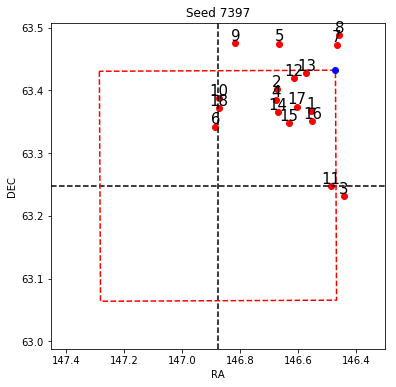

In [82]:
plt.figure(figsize=(6,6))

for i in xrange(18):
    plt.plot(segment_RADEC[i,0], segment_RADEC[i,1], 'ro', markersize=6)
    plt.annotate(str(i+1), xy=(segment_RADEC[i,0], segment_RADEC[i,1]), fontsize=15, ha='center', va='bottom' )

deltadeg = 0.26
plt.xlim( target[0]-deltadeg/np.cos(target[1]*np.pi/180.), target[0]+deltadeg/np.cos(target[1]*np.pi/180.)  )
plt.ylim( target[1]-deltadeg, target[1]+deltadeg )
plt.axvline(x=target[0], color='black', linestyle='--')
plt.axhline(y=target[1], color='black', linestyle='--')

obs1width = 2.2*10./60.
left  = obs1width/2. 
right =-obs1width/2. 
top   = obs1width/2.
bottom=-obs1width/2.

corners = np.array([ [left,top], [left, bottom], [right, bottom], [right, top], [left,top] ])
corners = shift_rotate_pts(corners, -rotation, target[1]) + target

plt.plot(corners[:,0], corners[:,1], color='red', linestyle='--') 
plt.plot(corners[3,0], corners[3,1], 'bo')

plt.xlabel("RA")
plt.ylabel("DEC")
plt.gca().invert_xaxis()
plt.title("Seed {:d}".format(seed))
plt.show()

# MAIN LOOP: DECIDE WHICH OBSERVATION TO "RUN"

In [83]:
# CHOOSE WHICH OTE-01 OBSERVATION TO EXECUTE (1 to 7):
#       Obs 1: Central
#       Obs 2: East
#       Obs 3: West
#       Obs 4: SouthEast
#       Obs 5: SouthWest
#       Obs 6: NorthEast
#       Obs 7: NorthWest
obs = 7

#outdir       = 'Obs{:d}_test{:d}/'.format(obs, bindim)
outdir       = 'Obs{:d}/'.format(obs)
if not os.path.isdir(outdir): os.mkdir(outdir)

# MAIN LOOP: EXECUTE THE SELECTED OBSERVATION

In [84]:
tile = NRCtile(target, rotation)

obs_dithers = dithers[obs-1]
print len(obs_dithers), "pointings"

# THIS IS OUR DEFAULT PSF THAT WE STITCH ON THE MOSAIC WHERE THERE ARE SEGMENTS:
if random_segs: 
    centeredPSF = read18PSF(psf18file) #centerPSF(psffile)
else: 
    centeredPSF = read18PSF(psf18file)


# FOR EACH DITHER POINT, CREATE IMAGES. IF A SEGMENT IS THERE, USE THE centeredPSF:
for itile in xrange( len(obs_dithers) ):   
    #print itile,obs_dithers[itile]
    seg_found = tile.assignWCS(obs, itile, target, obs_dithers[itile], darkfile, centeredPSF, segment_RADEC, bindim, seg_found, outdir, inputhistory)
 
    
print "\nFOUND {:d} SEGMENTS".format(np.count_nonzero(seg_found))

45 pointings
Found Segment #7 on SCA (1/18)
   --> Obs7/test0017.fits
Found Segment #7 on SCA (1/18)
   --> Obs7/test0036.fits
Found Segment #7 on SCA (1/18)
   --> Obs7/test0088.fits
Found Segment #8 on SCA (2/18)
   --> Obs7/test0089.fits
Found Segment #8 on SCA (2/18)
   --> Obs7/test0108.fits
Found Segment #7 on SCA (2/18)
   --> Obs7/test0109.fits
Found Segment #5 on SCA (3/18)
   --> Obs7/test0112.fits
Found Segment #9 on SCA (4/18)
   --> Obs7/test0128.fits
Found Segment #5 on SCA (4/18)
   --> Obs7/test0133.fits
Found Segment #9 on SCA (4/18)
   --> Obs7/test0138.fits

FOUND 4 SEGMENTS


# PLOT FOUND/MISSING SEGMENTS

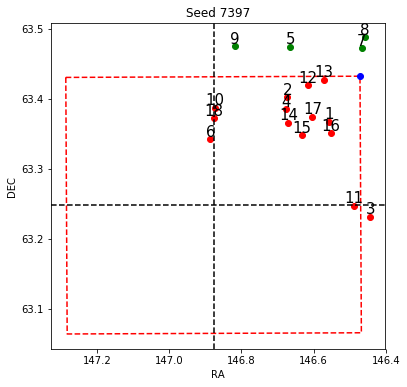

In [75]:
plt.figure(figsize=(6,6))

for i in xrange(18):
    if seg_found[i]==0: 
        plt.plot(segment_RADEC[i,0], segment_RADEC[i,1], 'ro', markersize=6)
        plt.annotate(str(i+1), xy=(segment_RADEC[i,0], segment_RADEC[i,1]), fontsize=15, ha='center', va='bottom' )
    if seg_found[i]==1: 
        plt.plot(segment_RADEC[i,0], segment_RADEC[i,1], 'go', markersize=6)
        plt.annotate(str(i+1), xy=(segment_RADEC[i,0], segment_RADEC[i,1]), fontsize=15, ha='center', va='bottom')

plt.plot(corners[:,0], corners[:,1], color='red', linestyle='--') 
plt.plot(corners[3,0], corners[3,1], 'bo')

plt.axvline(x=target[0], color='black', linestyle='--')
plt.axhline(y=target[1], color='black', linestyle='--')

plt.xlabel("RA")
plt.ylabel("DEC")
plt.gca().invert_xaxis()
plt.title("Seed {:d}".format(seed))
plt.show()

# PREPARE QUIP OPERATION XML FILE 

In [76]:
#outdir="Obs5/"

nfiles = len( glob.glob(outdir+"/*.fits") )
print nfiles

opsfile = 'ops_file_'+outdir.strip('/')+'.xml'
f = open(opsfile,'w')

f.write('<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n')
f.write('<QUIP_OPERATION_FILE xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="WSS Executive" time="16:22:40.093Z" date="2017-06-14Z" version="6.0.1" operational="false" xsi:noNamespaceSchemaLocation="/Users/lajoie/TEL/WSS-6.0.1/Software/schema/quip_operation_file.xsd">\n')
f.write('    <CORRECTION_ID>R2017061401</CORRECTION_ID>\n')
f.write('    <OPERATION_TYPE>THUMBNAIL</OPERATION_TYPE>\n')
f.write('    <IMAGES>\n')

for i in xrange(nfiles):
    f.write("       <IMAGE_PATH>{:s}{:s}{:04d}.fits</IMAGE_PATH>\n".format(imgdir+outdir,"test",i))
    
f.write( '       </IMAGES>\n'    )
f.write( '       <OUTPUT>\n')
f.write( '           <OUTPUT_DIRECTORY>{:s}quip/</OUTPUT_DIRECTORY>\n'.format(imgdir))
f.write( '           <LOG_FILE_PATH>{:s}quip/R2017061401_quip_activity_log.xml</LOG_FILE_PATH>\n'.format(imgdir))
f.write( '           <OUT_FILE_PATH>{:s}quip/R2017061401_quip_out.xml</OUT_FILE_PATH>\n'.format(imgdir))
f.write( '       </OUTPUT>\n')

f.write('</QUIP_OPERATION_FILE>\n')

f.close()
if not os.path.isdir(imgdir+"quip/"): os.mkdir(imgdir+"quip/")

360
